In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/ronakchordia/stocks/GOOGL.csv
/kaggle/input/d/ronakchordia/stocks/ABBV.csv
/kaggle/input/d/ronakchordia/stocks/TSLA.csv
/kaggle/input/d/ronakchordia/stocks/MSFT.csv
/kaggle/input/d/ronakchordia/stocks/PLD.csv
/kaggle/input/d/ronakchordia/stocks/BA.csv
/kaggle/input/d/ronakchordia/stocks/AAPL.csv
/kaggle/input/d/ronakchordia/stocks/XOM.csv
/kaggle/input/d/ronakchordia/stocks/BLK.csv
/kaggle/input/d/ronakchordia/stocks/PFE.csv
/kaggle/input/d/ronakchordia/stocks/COP.csv
/kaggle/input/d/ronakchordia/stocks/MRK.csv
/kaggle/input/d/ronakchordia/stocks/NVDA.csv
/kaggle/input/d/ronakchordia/stocks/SBUX.csv
/kaggle/input/d/ronakchordia/stocks/AMZN.csv
/kaggle/input/d/ronakchordia/stocks/ADBE.csv
/kaggle/input/d/ronakchordia/stocks/BAC.csv
/kaggle/input/d/ronakchordia/stocks/LIN.csv
/kaggle/input/d/ronakchordia/stocks/JNJ.csv
/kaggle/input/d/ronakchordia/stocks/AMD.csv
/kaggle/input/d/ronakchordia/stocks/CRM.csv
/kaggle/input/d/ronakchordia/stocks/FCX.csv
/kaggle/input/d/ronakch

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import warnings
import torch
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(device)

cuda


In [5]:
aapl=pd.read_csv("/kaggle/input/d/ronakchordia/stocks/GOOGL.csv")
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1600 non-null   object 
 1   Open      1600 non-null   float64
 2   High      1600 non-null   float64
 3   Low       1600 non-null   float64
 4   Close     1600 non-null   float64
 5   Volume    1600 non-null   int64  
 6   SMA_14    1600 non-null   float64
 7   SMA_26    1600 non-null   float64
 8   SMA_50    1600 non-null   float64
 9   SMA_100   1600 non-null   float64
 10  SMA_200   1600 non-null   float64
 11  EMA_14    1600 non-null   float64
 12  EMA_26    1600 non-null   float64
 13  EMA_50    1600 non-null   float64
 14  EMA_100   1600 non-null   float64
 15  EMA_200   1600 non-null   float64
 16  BB_Hband  1600 non-null   float64
 17  BB_Mband  1600 non-null   float64
 18  BB_Lband  1600 non-null   float64
 19  RSI_14    1600 non-null   float64
 20  Mean_HL   1600 non-null   floa

In [6]:
data_dir = "/kaggle/input/d/ronakchordia/stocks"

In [7]:
close_data = {}

# ✅ 2. Load 'Date' and 'Close' only from all tickers (ignore SPY)
for file in os.listdir(data_dir):
    if file.endswith(".csv") and file.upper() != "SPY.CSV":
        ticker = file.replace(".csv", "")
        path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(path, usecols=["Date", "Close"])
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df.set_index("Date", inplace=True)
            df = df[["Close"]].rename(columns={"Close": ticker})
            close_data[ticker] = df
        except Exception as e:
            print(f"⚠️ Skipped {ticker}: {e}")

In [8]:
price_df = pd.concat(close_data.values(), axis=1)
price_df.dropna(inplace=True)

In [9]:
price_df.head()

,GOOGL,ABBV,TSLA,MSFT,PLD,BA,AAPL,XOM,BLK,PFE,...,HON,CVX,CAT,JPM,NEE,META,GS,DUK,HD,AMT
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-16,56.449364,69.546310,18.439333,103.964432,54.155453,356.182556,52.803131,59.657154,346.788879,31.670357,...,135.154526,88.555916,123.973625,90.689362,36.640392,158.175766,190.480820,62.046329,166.063080,124.874329
2018-10-17,56.175861,69.818710,18.118668,103.692802,53.307426,353.522705,52.574932,59.877586,350.061249,32.131763,...,133.875504,88.390137,121.929092,91.699608,36.539856,158.813339,196.134232,61.915993,158.848541,125.722824
2018-10-18,54.697220,68.025391,17.594000,101.622894,53.485516,347.574219,51.346077,60.134720,339.878540,31.720819,...,131.452927,88.525780,117.149933,90.246864,36.700291,154.330460,193.273087,62.291630,154.790924,125.817162
2018-10-19,55.059406,66.564995,17.333332,101.772751,53.926498,344.585480,52.128086,60.222897,341.391510,32.081291,...,129.996033,89.030685,114.007195,90.096550,37.104576,153.463791,195.000092,63.433830,154.284790,128.697083
2018-10-22,55.367786,63.765282,17.396667,102.681252,53.646629,344.314667,52.446590,59.620434,333.495239,31.987566,...,129.267578,88.329834,111.741287,88.802422,36.933445,154.190979,190.394882,63.349491,153.341141,127.925713


In [10]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1600 entries, 2018-10-16 to 2025-02-27
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGL   1600 non-null   float64
 1   ABBV    1600 non-null   float64
 2   TSLA    1600 non-null   float64
 3   MSFT    1600 non-null   float64
 4   PLD     1600 non-null   float64
 5   BA      1600 non-null   float64
 6   AAPL    1600 non-null   float64
 7   XOM     1600 non-null   float64
 8   BLK     1600 non-null   float64
 9   PFE     1600 non-null   float64
 10  COP     1600 non-null   float64
 11  MRK     1600 non-null   float64
 12  NVDA    1600 non-null   float64
 13  SBUX    1600 non-null   float64
 14  AMZN    1600 non-null   float64
 15  ADBE    1600 non-null   float64
 16  BAC     1600 non-null   float64
 17  LIN     1600 non-null   float64
 18  JNJ     1600 non-null   float64
 19  AMD     1600 non-null   float64
 20  CRM     1600 non-null   float64
 21  FCX     1600 non-nu

In [11]:
log_returns = np.log(price_df / price_df.shift(1)).dropna()

In [12]:
tickers = log_returns.columns.tolist()
mu = log_returns.mean().values
cov = LedoitWolf().fit(log_returns).covariance_
S0 = price_df.loc[log_returns.index[-1], tickers].values
weights = np.ones(len(tickers)) / len(tickers)  # equal weight

In [13]:
#Monte Carlo simulation
#The Monte Carlo simulation models the evolution of a portfolio’s value over time by 
# numerically generating multiple random future paths based on historical asset return dynamics. 
# We assume asset prices follow a multivariate geometric Brownian motion (GBM), 
# where the log returns are normally distributed and correlated according to the 
# empirical mean vector (μ) and covariance matrix (Σ), estimated from historical log returns. 
# At each simulated step (daily), we draw a random shock from a multivariate normal 
# distribution using N(μ, Σ), exponentiate it to model multiplicative price evolution 
# (S_t+1 = S_t * exp(z)), and compute the portfolio value via a dot product with the weight vector. 
# This process is repeated over a 30-day horizon for 100,000 iterations, resulting in a distribution 
# of possible portfolio outcomes. The simulation allows us to derive distributional properties of 
# future portfolio values, including percentile bands, median trajectory, and tail risk metrics such as 
# Value at Risk (VaR) and Conditional Value at Risk (CVaR).
# Convert inputs to torch tensors on GPU
mu_torch = torch.tensor(mu, dtype=torch.float32, device=device)
cov_torch = torch.tensor(cov, dtype=torch.float32, device=device)
S0_torch = torch.tensor(S0, dtype=torch.float32, device=device)
weights_torch = torch.tensor(weights, dtype=torch.float32, device=device)

n_days = 300
n_sim = 10000
sim_paths = torch.zeros((n_days, n_sim), dtype=torch.float32, device=device)

# Create multivariate normal distribution (GPU-backed)
dist = torch.distributions.MultivariateNormal(mu_torch, covariance_matrix=cov_torch)

# Monte Carlo Simulation
for i in tqdm(range(n_sim), desc="Simulating paths"):
    prices = S0_torch.clone()
    path = []
    for _ in range(n_days):
        shock = dist.sample()
        prices *= torch.exp(shock)
        path.append(torch.dot(prices, weights_torch))
    sim_paths[:, i] = torch.stack(path)

Simulating paths: 100%|██████████| 10000/10000 [05:17<00:00, 31.53it/s]


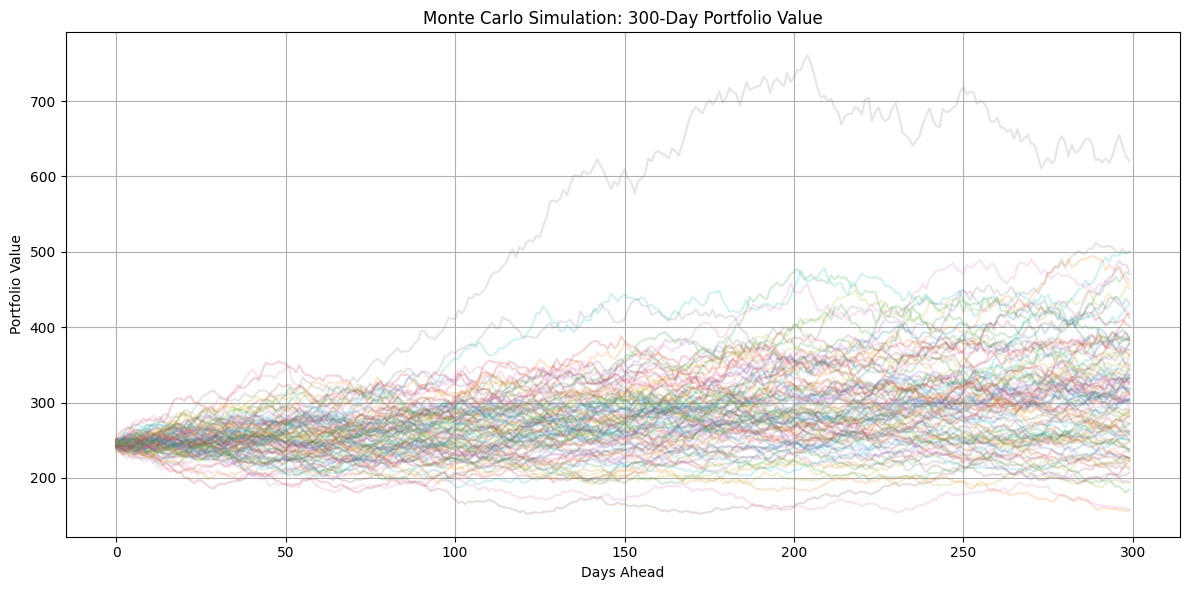

In [14]:
# ✅ 7. Plot simulation paths
sim_paths_cpu = sim_paths[:, :100].cpu().numpy()  # Move to CPU
plt.figure(figsize=(12, 6))
plt.plot(sim_paths_cpu, alpha=0.2)
plt.title("Monte Carlo Simulation: 300-Day Portfolio Value")
plt.xlabel("Days Ahead")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


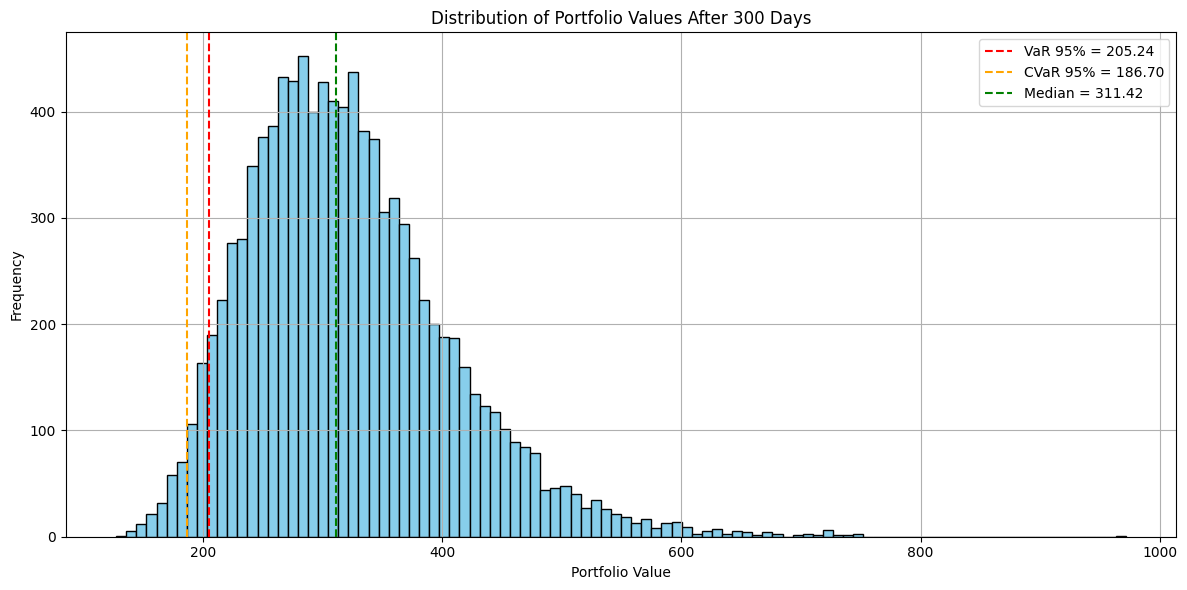

In [15]:
# ✅ 8. Risk metrics
final_vals = sim_paths[-1, :].cpu().numpy()  # Convert to NumPy
VaR_95 = np.percentile(final_vals, 5)
CVaR_95 = final_vals[final_vals <= VaR_95].mean()
median = np.percentile(final_vals, 50)
# ✅ Final value histogram
plt.figure(figsize=(12, 6))
plt.hist(final_vals, bins=100, color='skyblue', edgecolor='black')
plt.axvline(VaR_95, color='red', linestyle='--', label=f'VaR 95% = {VaR_95:.2f}')
plt.axvline(CVaR_95, color='orange', linestyle='--', label=f'CVaR 95% = {CVaR_95:.2f}')
plt.axvline(median, color='green', linestyle='--', label=f'Median = {median:.2f}')
plt.title("Distribution of Portfolio Values After 300 Days")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# ✅ 8. Risk metrics
print(f"✅ Simulation complete using {len(tickers)} tickers")
print(f"📈 Starting Portfolio Value: {np.dot(S0, weights):.2f}")
print(f"📉 30-Day VaR (95%): {VaR_95:.2f}")
print(f"📉 30-Day CVaR (95%): {CVaR_95:.2f}")

✅ Simulation complete using 32 tickers
📈 Starting Portfolio Value: 245.02
📉 30-Day VaR (95%): 205.24
📉 30-Day CVaR (95%): 186.70
